In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import threading
import math
import pandas as pd
from scipy.optimize import minimize
import asyncio
import datetime
import hashlib
import os
import json

In [2]:
def change(filename):
        f = open(f"{filename}.txt", "r")
        out = open(f"{filename}.csv", "w")
        for line in f:
                change = line.replace("\t", ",")
                out.write(change)

In [3]:
change("Demand")

In [4]:
def read_file(filename):
    with open(filename,"r") as f:
        df = pd.read_csv(f,header=None)
        return df.to_numpy()

In [5]:
shops = read_file("Demand.csv")
values = np.array(shops[:, 3])
points = np.array(shops[:, 1:3])
x_range = [1, 9]
y_range = [0, 9]
n = len(values)
cost = 600
prohibited_rectangles = [((3.5, 5.2), (4.8, 6.2)), ((2.7, 3.3),  (3.0, 3.8)), ((3.2, 3.0),  (3.8, 3.4)), ((4.7, 4.2), (5.0, 4.5)), ((5.9, 2.9),  (6.2, 3.8))]
prohibited_circles = [((6.25, 7.45), 0.75)]
anss = [100000] * n

In [6]:
def le(x, y):
    epsilon = 1e-9
    return (x - y) >= epsilon
def is_in_prohibited_area(point, prohibited_rectangles, prohibited_circles):
    x, y = point
    for (x1, y1), (x2, y2) in prohibited_rectangles:
        if le(x, x1) and le(x2, x) and le(y, y1) and le(y2, y):
            return True
    for (xc, yc), radius in prohibited_circles:
        if le(radius, np.linalg.norm([x - xc, y - yc])):
            return True
    return False

# Function to perform constrained KMeans clustering
def constrained_kmeans(points, values, max_sum, m):
    clusters = KMeans(n_clusters=m).fit(points)
    labels = clusters.labels_
    
    while True:
        cluster_sums = [np.sum(values[labels == i]) for i in range(m)]
        if all(sum_val < max_sum for sum_val in cluster_sums):
            break
        for i, sum_val in enumerate(cluster_sums):
            if sum_val >= max_sum:
                indices = np.where(labels == i)[0]
                np.random.shuffle(indices)
                for idx in indices:
                    for j in range(m):
                        if j != i and np.sum(values[labels == j]) + values[idx] < max_sum:
                            labels[idx] = j
                            break
    return labels

# Modified function to find the geometric median avoiding prohibited areas
def geometric_median_avoid_prohibited(X, weights, prohibited_rectangles, prohibited_circles, eps=1e-5):
    def objective(y):
        penalty = 0
        if is_in_prohibited_area(y, prohibited_rectangles, prohibited_circles):
            penalty = 1e6  # Large penalty for points inside prohibited areas
        distances = cdist(X, [y])
        weighted_sum = np.sum(distances * weights[:, np.newaxis])
        return weighted_sum + penalty
    
    y = np.mean(X, axis=0)
    result = minimize(objective, y, method='SLSQP')
    return result.x

# Function to calculate weighted sum of distances
def calculate_weighted_sum_of_distances(medians, points, values, labels):
    weighted_sums_of_distances = []
    for i, median in enumerate(medians):
        if median is not None:
            cluster_points = points[labels == i]
            cluster_values = values[labels == i]
            distances = np.linalg.norm(cluster_points - median, axis=1)
            weighted_distances = distances * cluster_values
            weighted_sum_of_distances = np.sum(weighted_distances)
            weighted_sums_of_distances.append(weighted_sum_of_distances)
        else:
            weighted_sums_of_distances.append(None)
    return weighted_sums_of_distances

# Function to plot clusters
def plot_clusters(points, labels, medians, filename='clusters_with_medians.png'):
    plt.ioff()
    plt.figure(figsize=(15, 15))
    colors = plt.get_cmap('tab10', len(medians))
    for i in range(len(medians)):
        cluster_points = points[labels == i]
        if len(cluster_points) > 0:
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors(i), label=f'Cluster {i}')
            if medians[i] is not None:
                plt.scatter(medians[i][0], medians[i][1], color='black', marker='x', s=100, label=f'Median {i}')
                for point in cluster_points:
                    plt.plot([medians[i][0], point[0]], [medians[i][1], point[1]], color=colors(i), linestyle='-')
    # Plot prohibited rectangles
    for (x1, y1), (x2, y2) in prohibited_rectangles:
        plt.fill([x1, x2, x2, x1], [y1, y1, y2, y2], color='Aquamarine', alpha=1)
    # Plot prohibited circles
    for (xc, yc), radius in prohibited_circles:
        circle = plt.Circle((xc, yc), radius, color='Aquamarine', alpha=1)
        plt.gca().add_patch(circle)
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Clusters and Geometric Medians with Connecting Lines')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename, dpi=300)
    plt.close()


# Main function to run the tasks
def run_task(idx, points, values, startm, endm, max_sum, try_num):
    file_name = f"Task{idx}.txt"
    f = open(file_name, "w")
    f1 = open(f"Task{idx}_location.txt", "w")
    print(f"Thread {idx} started")
    for m in range(startm, endm):
        k = [100000] * 5
        runtime = 0
        while runtime <= try_num:
            labels = constrained_kmeans(points, values, max_sum, m)
            geometric_medians = []
            ans = 0
            check = True
            for i in range(m):
                cluster_values = values[labels == i]
                cluster_points = points[labels == i]
                if len(cluster_points) > 0:
                    geometric_median_point = geometric_median_avoid_prohibited(cluster_points, cluster_values, prohibited_rectangles, prohibited_circles)
                    geometric_medians.append(geometric_median_point)
                else:
                    geometric_medians.append(None)
                    check = False
                    break
            if check == False:
                #print(f"Runtime {runtime} of {m} cannot find geometric medians for all clusters")
                continue
            
            weighted_sums_of_distances = calculate_weighted_sum_of_distances(geometric_medians, points, values, labels)

            for i, sum_dist in enumerate(weighted_sums_of_distances):
                if sum_dist is not None:
                    ans += sum_dist
            ans += cost * m
            check = True
            # print(f"Minimum cost is {ans}")
            for i, median in enumerate(geometric_medians):
                if median is not None and is_in_prohibited_area(median, prohibited_rectangles, prohibited_circles):
                    check = False
                    print(f"Wrong on constraints of {runtime} of {m}")
            if check:
                #plot_clusters(points, labels, geometric_medians, filename=f'Task{idx}_m{m}_runtime{runtime}.png')
                runtime += 1
                if k[0] > ans:
                    k[0] = ans
                    k[1] = m
                    k[2] = labels
                    k[3] = geometric_medians
                    k[4] = weighted_sums_of_distances
        anss[m] = k[0]
        f.write(f"{k[0]} {k[1]} \n")
        f1.write(f"{k[1]} \n")
        for i, median in enumerate(k[3]):
            f1.write(f"{median} \n")
    print(f"Thread {idx} finished")
                    
            
            


if __name__ == "__main__":
    max_sum = 1000
    threads = []
    try_num = 3
    for i in range(1, 10):
        startm = i * 20 + 1
        endm = (i + 1) * 20 + 1
        t = threading.Thread(target=run_task, args=(i, points, values, startm, endm, max_sum, try_num))
        threads.append(t)
        t.start()
    
    for t in threads:
        t.join()
    print("All threads have finished.")
    run_task(0, points, values, 6, 21, max_sum, try_num)
    print("Completed all tasks.")

Thread 1 started
Thread 2 started
Thread 3 started
Thread 4 started
Thread 5 started
Thread 6 started
Thread 7 started
Thread 8 started
Thread 9 started


Exception in thread Thread-15 (run_task):
Traceback (most recent call last):
  File "c:\Python312\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Python312\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_31148\3219262190.py", line 146, in run_task
TypeError: 'int' object is not iterable


Thread 1 finished


Exception in thread Thread-12 (run_task):
Traceback (most recent call last):
  File "c:\Python312\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Python312\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_31148\3219262190.py", line 146, in run_task
TypeError: 'int' object is not iterable


Thread 2 finished
Thread 3 finished
Thread 4 finished
Thread 5 finished
Thread 6 finished
Thread 7 finished
All threads have finished.
Thread 0 started
Thread 0 finished
Completed all tasks.


7420.885217560588


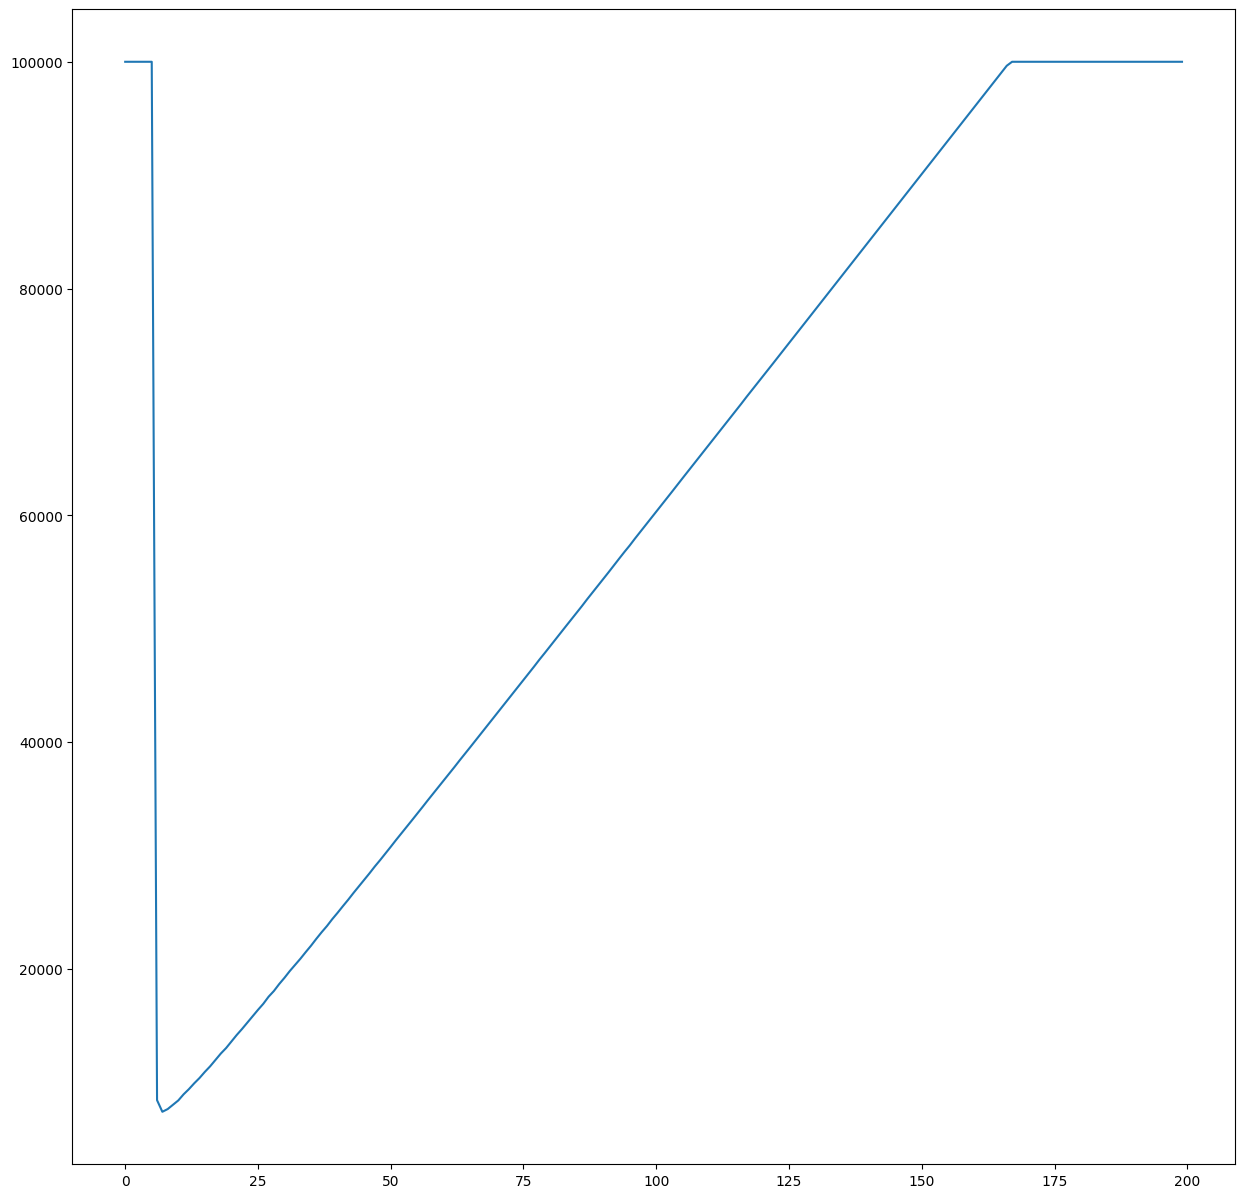

In [7]:
plt.figure(figsize=(15,15))
plt.plot(anss)
plt.savefig("TotalCost.png", dpi = 300)
plt.show()

In [8]:
print(anss.index(min(anss)))

7
